In [ ]:
#!kaggle competitions download -c nlp-getting-started

In [1]:
import pandas as pd
import numpy as np
import os


import matplotlib.pyplot as plt

import emoji

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout, SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
import keras.backend as K 
from keras.callbacks import EarlyStopping

from keras.models import load_model


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer  
from tensorflow.keras.preprocessing.text import text_to_word_sequence

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *





Using TensorFlow backend.


In [2]:
train = pd.read_csv("/Users/reejungkim/Documents/Git/Sentimental analysis/nlp-getting-started/train.csv")
test = pd.read_csv("/Users/reejungkim/Documents/Git/Sentimental analysis/nlp-getting-started/test.csv")

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
df = pd.concat([train, test], axis=0).reset_index(drop=True)

In [6]:
train.shape, test.shape, df.shape

((7613, 5), (3263, 4), (10876, 5))

In [7]:
df.tail()

,id,keyword,location,text,target
10871,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
10872,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
10873,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
10874,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN
10875,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN


In [8]:
not_disaster = df.loc[df.target==0]
disaster = df.loc[df.target==1]

# EDA

In [9]:
for i in range(0, 10):
    print(i ,". ", disaster.text[i], "target: ",disaster.target[i] ) 

0 .  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all target:  1.0
1 .  Forest fire near La Ronge Sask. Canada target:  1.0
2 .  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected target:  1.0
3 .  13,000 people receive #wildfires evacuation orders in California  target:  1.0
4 .  Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school  target:  1.0
5 .  #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires target:  1.0
6 .  #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas target:  1.0
7 .  I'm on top of the hill and I can see a fire in the woods... target:  1.0
8 .  There's an emergency evacuation happening now in the building across the street target:  1.0
9 .  I'm afraid that the tornado is coming to our area... target:  1.0


In [10]:
disaster.loc[pd.notnull(disaster.keyword)].head(3)

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1.0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1.0
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1.0


In [11]:
disaster.loc[pd.notnull(disaster.location)].head(3)

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1.0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1.0
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1.0


# Feature engineering

In [12]:
def find_url(string): 
    text = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',string)
    if text!=[]:
        return "".join(text)
    return None

In [13]:
df['url']= df['text'].apply(lambda x:find_url(x))
df.loc[pd.notnull(df.url)]

,id,keyword,location,text,target,url
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1.0,http://t.co/lHYXEOHY6C
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0.0,http://t.co/YAo1e0xngw
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1.0,http://t.co/2nndBGwyEi
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0.0,http://t.co/qqsmshaJ3N
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1.0,http://t.co/3ImaomknnA
...,...,...,...,...,...,...
10865,10836,NaN,NaN,#Ebola #EbolaOutbreak Ebola Virus: Birmingham ...,NaN,http://t.co/tjpYlU9fOX
10866,10838,NaN,NaN,Malaysian PM confirms debris is from missing f...,NaN,http://t.co/pfAvW5QyqE
10868,10856,NaN,NaN,See the 16yr old PKK suicide bomber who detona...,NaN,http://t.co/hKuT5mSdtP
10873,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN,http://t.co/UtbXLcBIuY


In [14]:
def extract_emojis(string):
    emoticon = "".join(c for c in string if c in emoji.UNICODE_EMOJI)
    if emoticon!="":
        return emoticon
    return None

extract_emojis("😘😳😍test")

'😘😳😍'

In [15]:
df['emoji']= df['text'].apply(lambda x: extract_emojis(x))

# process text

In [16]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


In [17]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

In [18]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [19]:
df.text = df.text.apply(lambda x: remove_emoji(x))

In [20]:
stops = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
lm = WordNetLemmatizer()

In [21]:
def language_preprocessor(string):
    text =  re.sub('[^a-zA-Z]', ' ', string) #replace non-english with blank
    text = text.lower().split() #decapitalize texts
    text = [word for word in text if not word in stops] #remove stopword
    text = [lm.lemmatize(word) for word in text]  #lemmatization of texts
    return text #' '.join(text)  #text
    

In [22]:
df['text processed'] = df['text'].apply(lambda x: language_preprocessor(x)) 

In [23]:
df.head(3)

,id,keyword,location,text,target,url,emoji,text processed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,None,None,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,None,None,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,None,None,"[resident, asked, shelter, place, notified, of..."


In [24]:
from collections import Counter

def common_words(df, col, n):
    counts = Counter([item for sublist in df[col] for item in sublist])
    common_words = pd.DataFrame(counts.most_common(n))
    common_words.columns =['Word','count']
    return common_words
    

In [25]:
disaster_common_words  = common_words(df.loc[df.target==1], 'text processed', 30)
disaster_common_words.head(5)

,Word,count
0,fire,268
1,news,151
2,amp,135
3,disaster,122
4,via,121


In [26]:
words = disaster_common_words.set_index("Word")['count'].to_dict()

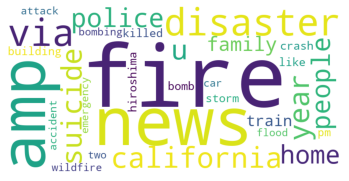

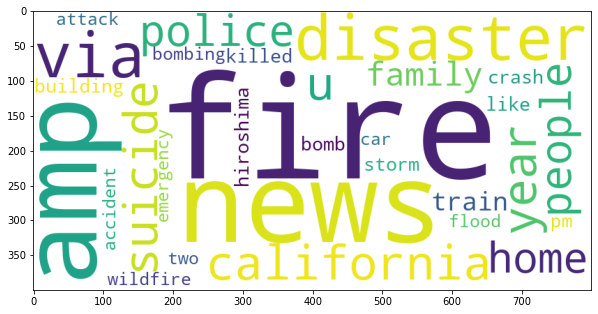

In [27]:
from wordcloud import WordCloud

wc = WordCloud(background_color='white',width=800, height=400)
wordcloud = wc.generate_from_frequencies(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.figure( figsize=(10,10) )
plt.imshow(wordcloud)
#plt.show()


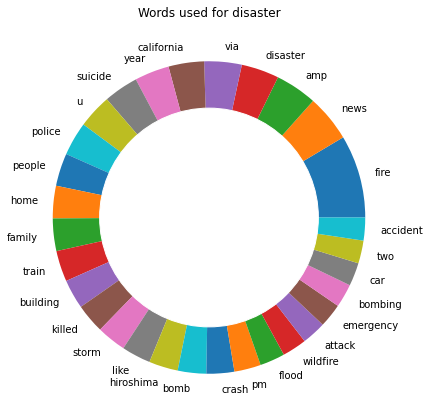

In [28]:
import matplotlib.pyplot as plt
#from palettable.colorbrewer.qualitative import Pastel1_7

plt.figure(figsize=(7,10))
my_circle=plt.Circle((0,0), 0.7, color='white')

plt.pie(disaster_common_words['count'], 
        labels=disaster_common_words.Word, startangle=-0) #,colors=Pastel1_7.hex_colors)

p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Words used for disaster')
plt.show()


# model application

In [29]:
train_data = df.loc[pd.notnull(df.target)]

In [30]:
train_data.tail(3)

,id,keyword,location,text,target,url,emoji,text processed
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.,1.0,http://t.co/zDtoyd8EbJ,None,"[utc, km, volcano, hawaii]"
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1.0,None,None,"[police, investigating, e, bike, collided, car..."
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1.0,http://t.co/YmY4rSkQ3d,None,"[latest, home, razed, northern, california, wi..."


In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text processed'])
X_data = tokenizer.texts_to_sequences(train_data['text processed']) 

In [32]:
#X_data

[[3987, 471, 168, 70, 1416, 3988, 4],
 [108, 1, 150, 558, 5888, 5889, 1074],
 [1540, 1417, 1714, 472, 5890, 322, 169, 1714, 472, 323, 966],
 [10, 3989, 81, 169, 323, 30],
 [42, 1075, 105, 5891, 1541, 195, 81, 5892, 101],
 [2583, 186, 30, 1235, 740, 967, 473, 913, 324, 1, 3990, 81],
 [40, 14, 710, 159, 126, 711, 187, 455, 5893, 914, 818, 135],
 [141, 1163, 43, 1, 1905],
 [15, 169, 1076, 20, 741, 455],
 [2178, 260, 175, 135],
 [474, 10, 537, 202, 131, 538],
 [742,
  456,
  2584,
  151,
  2585,
  3140,
  539,
  368,
  115,
  456,
  2584,
  245,
  245,
  5894,
  187],
 [2586, 187, 1418, 5895, 2584, 17, 595, 3141],
 [40, 3991, 776, 1419, 3991],
 [127, 101, 203, 2587, 41, 28, 261],
 [36],
 [47, 1542],
 [237, 1543],
 [41, 643],
 [5896],
 [2588],
 [860, 428],
 [47, 5897],
 [2179, 17],
 [5898],
 [71, 1715, 152],
 [1164, 78, 220],
 [47, 1906],
 [5899],
 [2, 3992],
 [188],
 [5900, 2589, 310, 515],
 [221, 679, 861, 710, 1077, 44],
 [5901, 261, 8, 2180, 596, 176, 515, 1022],
 [819, 176, 515],
 [154

In [33]:
word_to_index = tokenizer.word_index

In [ ]:
#word_to_index

In [34]:
len(word_to_index)

14831

In [35]:
max(len(i) for i in X_data)

25

In [36]:
vocab_size = len(word_to_index) + 1

In [37]:
max_len = max(len(i) for i in X_data)

# padding

In [38]:
X_data = pad_sequences(X_data, maxlen = max_len)

In [39]:
X_data.shape

(7613, 25)

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, train_data.target,
                                                    test_size=0.2, 
                                                    random_state=0)
 

In [41]:
np.array(X_train).shape, np.array(y_train).shape

((6090, 25), (6090,))

In [42]:
model = Sequential()
model.add(Embedding(vocab_size, 40)) 
model.add(SimpleRNN(40)) # RNN layers 
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [43]:
history = model.fit(X_train, np.array(y_train), 
                    epochs=4, 
                    batch_size=50, 
                    validation_split=0.2)

/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4872 samples, validate on 1218 samples
Epoch 1/4
4872/4872 [==============================] - 3s 634us/step - loss: 0.6331 - acc: 0.6406 - val_loss: 0.5195 - val_acc: 0.7578
Epoch 2/4
4872/4872 [==============================] - 2s 393us/step - loss: 0.3813 - acc: 0.8391 - val_loss: 0.5199 - val_acc: 0.7759
Epoch 3/4
4872/4872 [==============================] - 2s 389us/step - loss: 0.2355 - acc: 0.9128 - val_loss: 0.6048 - val_acc: 0.7323
Epoch 4/4
4872/4872 [==============================] - 2s 421us/step - loss: 0.1454 - acc: 0.9503 - val_loss: 0.6553 - val_acc: 0.7348


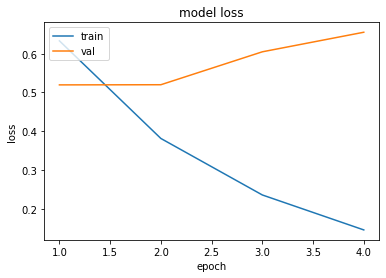

In [44]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
model.evaluate(X_test, np.array(y_test))

1523/1523 [==============================] - 0s 121us/step


[0.6196447572697171, 0.7367038726806641]

In [46]:
test_pred = model.predict(X_test)

In [47]:
test_pred

array([[0.18382832],
       [0.46615118],
       [0.4097017 ],
       ...,
       [0.23809762],
       [0.03460221],
       [0.5401153 ]], dtype=float32)

In [51]:
test_pred_target = test_pred.argmax(axis=-1)

In [48]:
y_test

311     0.0
4970    0.0
527     0.0
6362    0.0
800     0.0
       ... 
3728    1.0
1657    0.0
6367    1.0
1670    0.0
2839    1.0
Name: target, Length: 1523, dtype: float64

In [52]:
test_pred_target

array([0, 0, 0, ..., 0, 0, 0])

In [53]:
for pred, true in zip(np.squeeze(test_pred_target), y_test):
    print('Pred: {:.6f} - True: {:.6f}'.format(pred,true))

Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 1.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 1.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 1.000000
Pred: 0.000000 - True: 1.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 1.000000
Pred: 0.000000 - True: 1.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 1.000000
Pred: 0.000000 - True: 1.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 1.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.000000 - True: 0.000000
Pred: 0.

def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

list_corpus = df.text.loc[pd.notnull(df.target)].tolist()
list_labels = df.target.loc[pd.notnull(df.target)].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=0)
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)